# Displaying the results

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
Using device: cuda


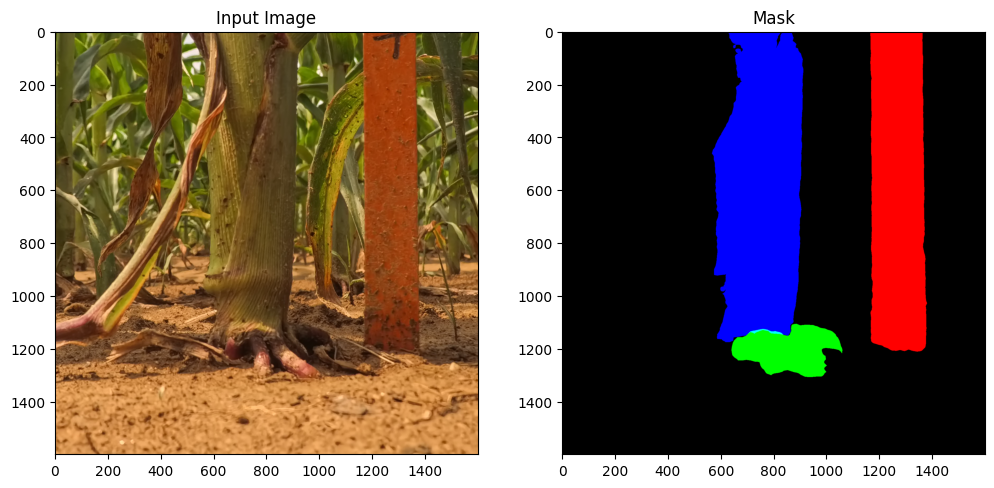

Using UNet_exp_2024
Using ResidualUNet_exp_2024


In [ ]:
import torch
from myCnns import *
from PIL import Image, ImageDraw
import numpy as np
import random
from pycocotools.coco import COCO

coco = COCO('./2024_annot/2024_annotations.json')

# Load a random sample from COCO

# Get all image ids
img_ids = coco.getImgIds()
# Select a random image id
img_id = random.choice(img_ids)
# Load the image information
img_info = coco.loadImgs(img_id)[0]

# Load the image
image_path = f"./2024_annot/images/{img_info['file_name']}"
image = Image.open(image_path)

# Load the annotations for the image
ann_ids = coco.getAnnIds(imgIds=img_id)
anns = coco.loadAnns(ann_ids)

# Create a mask for the image
mask = np.zeros((img_info['height'], img_info['width'],4), dtype=np.uint8)
for ann in anns:
    mask[:,:,ann['category_id']] += coco.annToMask(ann)
mask[:,:,0] = 1 - np.maximum.reduce([mask[:,:,i] for i in range(1, 4)])
mask = np.where(mask == 1, 255, mask)
# for i in range(4):
    
#     print(np.unique(mask[:,:,i]))
#     print(f'Max value in channel {i} of mask: {mask[:,:,i].max()}')
# Check if CUDA is available and use it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load the image

# Center crop the image to a size of 1024 pixels
width, height = image.size
new_width, new_height = 1600, 1600
left = int((width - new_width) / 2)
top = int((height - new_height) / 2)
right = int((width + new_width) / 2)
bottom = int((height + new_height) / 2)
image = image.crop((left, top, right, bottom))
# Center crop the mask to a size of 1024 pixels
mask = mask[top:bottom, left:right,:]
# for i in range(4):
#     print(np.unique(mask[:,:,i]))
#     print(f'Max value in channel {i} of mask: {mask[:,:,i].max()}')
# Transform the image to a tensor
image_tensor = torch.from_numpy(np.array(image)).unsqueeze(0).permute(0,3,1,2).float()
image_tensor = image_tensor.to(device)
import matplotlib.pyplot as plt
# Convert mask to image
mask_image = Image.fromarray(mask[:,:,1:].astype(np.uint8))
# Display the input image and mask
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image)
ax[0].set_title('Input Image')
ax[0].axis('on')
ax[1].imshow(mask_image)
ax[1].set_title('Mask')
ax[1].axis('on')
plt.show()
outputs =[]
for j in [UNet, ResidualUNet, SegNet, U2Net][:3]:
    model = j()
    model_name = f'{j.__name__}_exp_2024'
    print(f'Using {model_name}')
    model.load_state_dict(torch.load(f'./weights/{model_name}.pth',weights_only=True))
    model = model.to(device)
    outputs.append(model(image_tensor.squeeze(0)))
    del model

torch.Size([4, 1024, 1024])


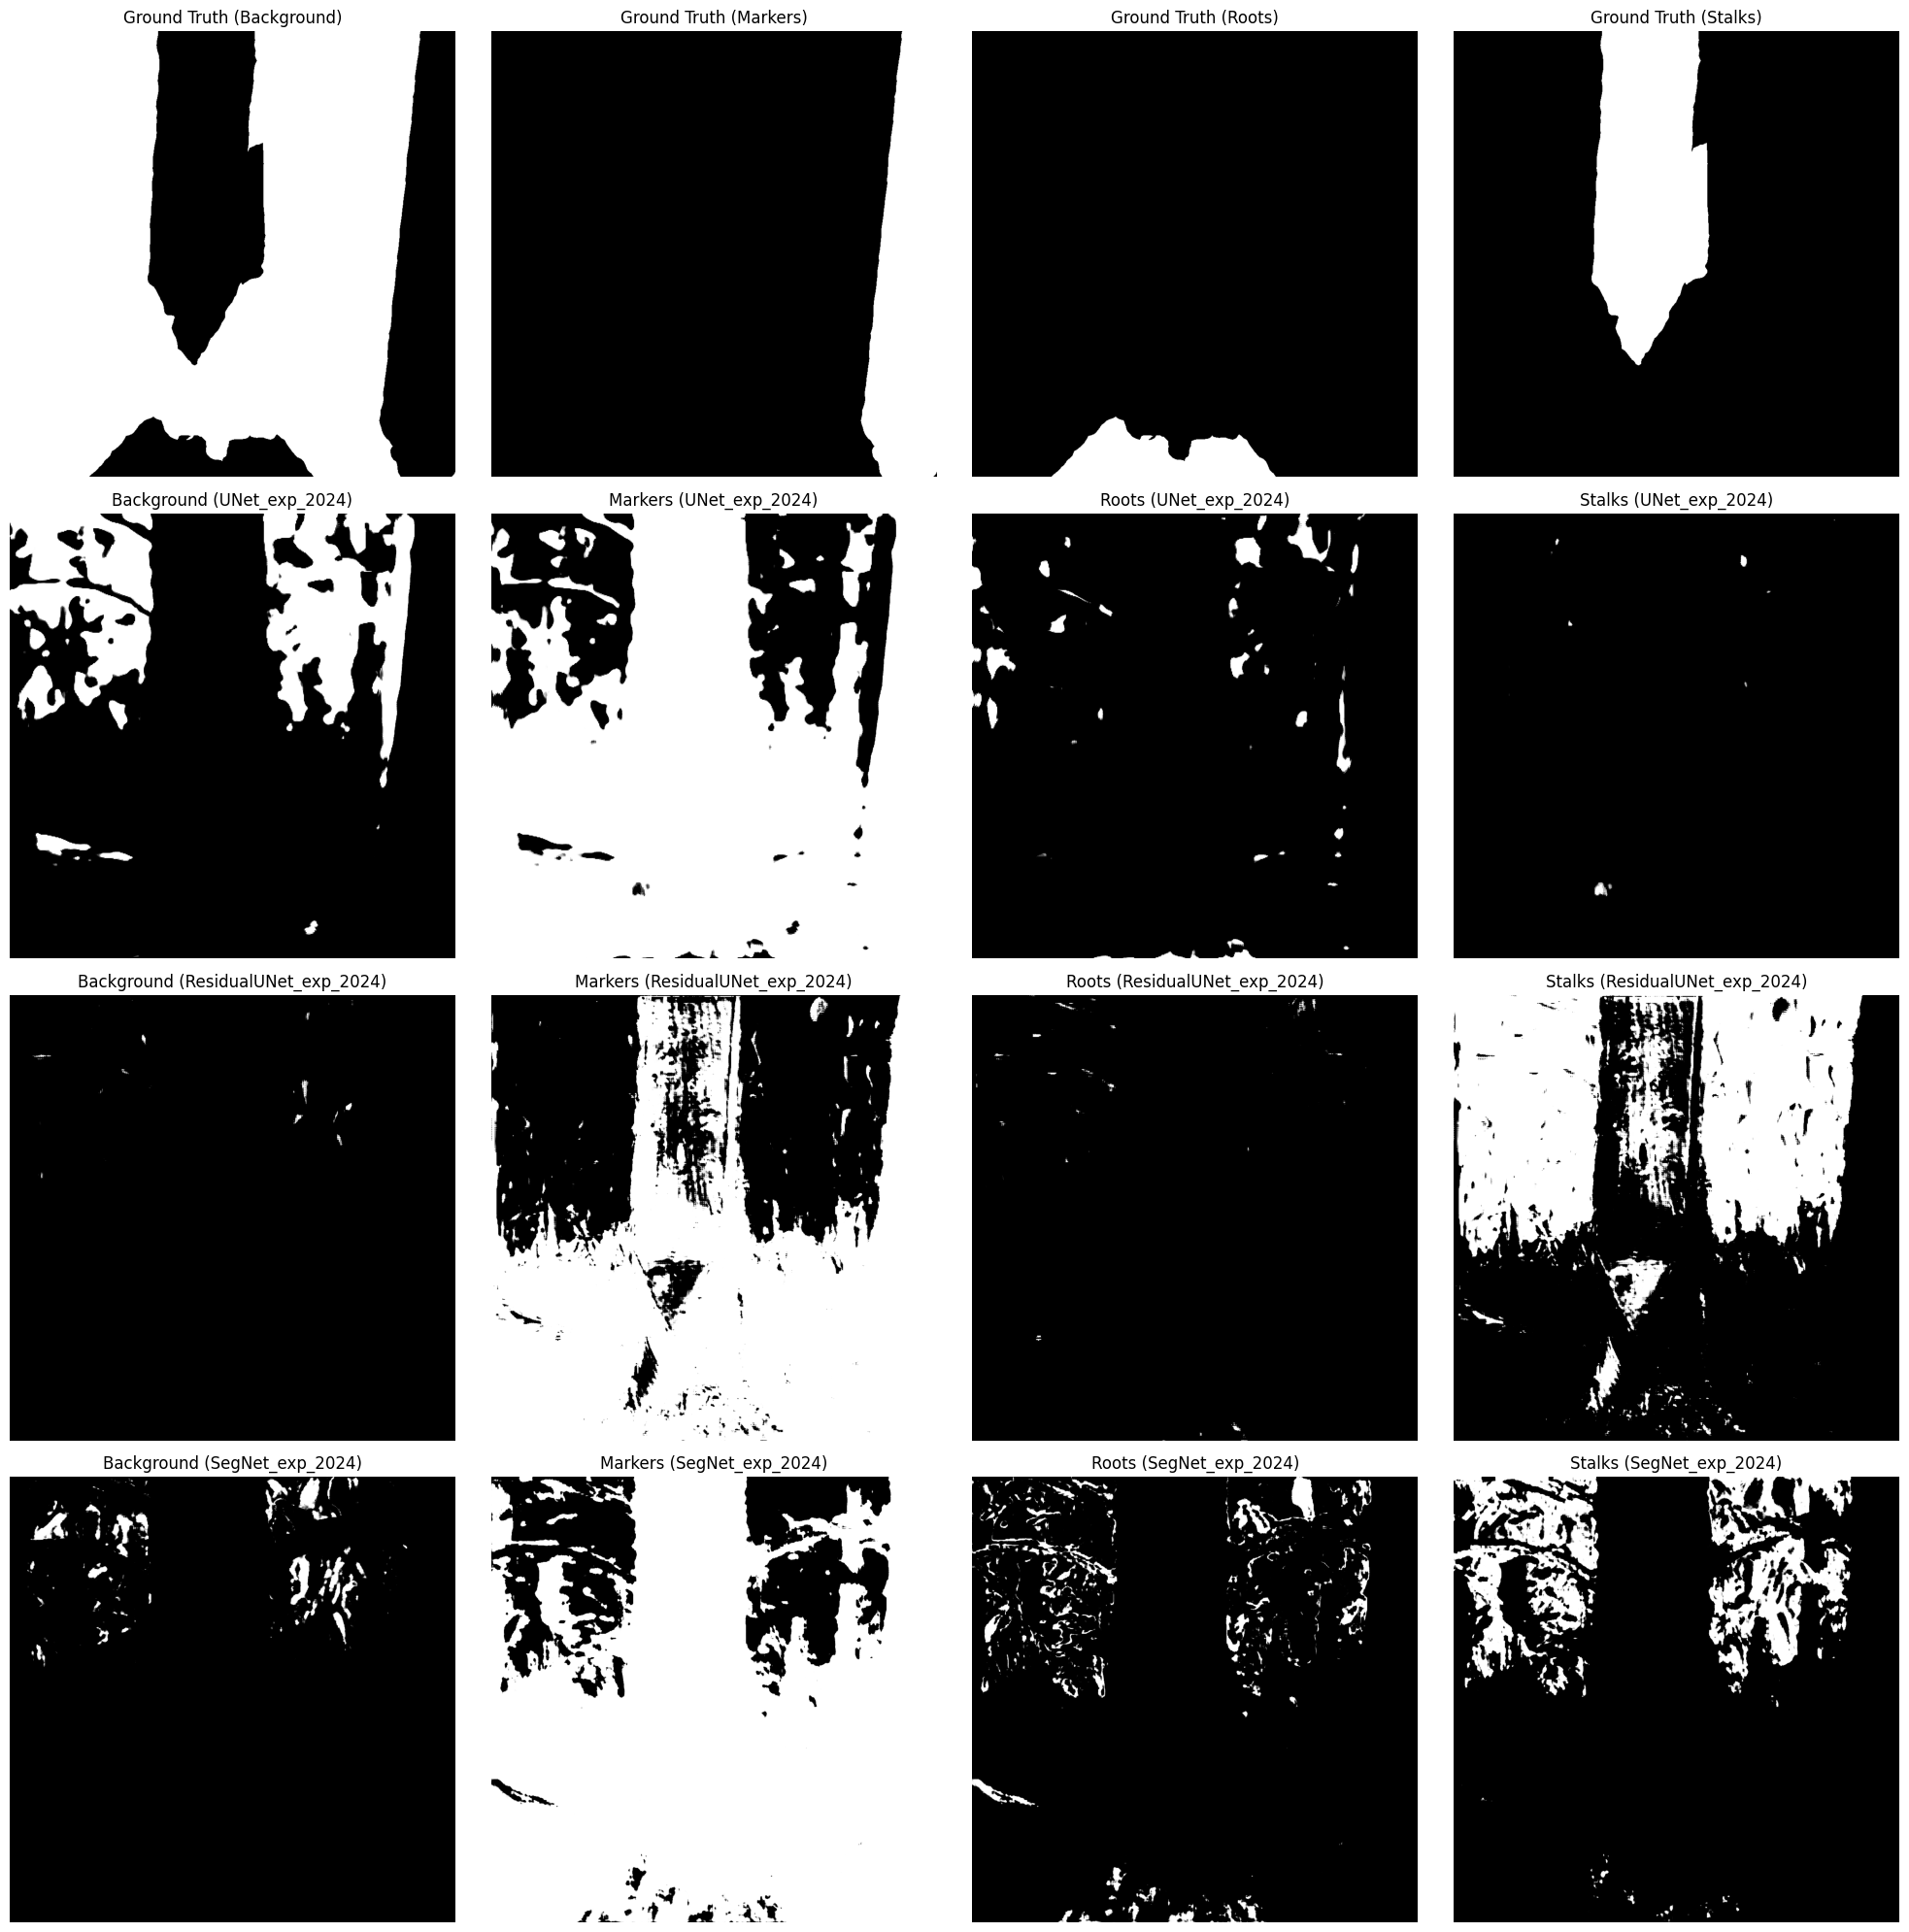

In [ ]:
print(outputs[0].shape)
output_image = outputs[0].detach().cpu().numpy()

output_image = torch.nn.functional.softmax(torch.tensor(output_image, dtype=torch.float32), dim=0).numpy()
# output_image = output_image[1:]
output_image = np.transpose(output_image, (1,2,0)) * 255
# output_image = (output_image - output_image.min()) / (output_image.max() - output_image.min()) * 255
output_image = output_image.astype(np.uint8)
# Assuming the output_image has 4 channels
channels = ['Background', 'Markers', 'Roots', 'Stalks']
model_names = ['UNet_exp_2024', 'ResidualUNet_exp_2024','SegNet_exp_2024']
# # Split the output image into 4 channels
# for i in range(4):
#     # channel_image = output_image[:, :, i]
#     # plt.imshow(channel_image, cmap='gray')
#     # plt.title(channels[i])
#     # plt.axis('off')
#     # plt.show()
fig, axes = plt.subplots(len(outputs) + 1, 4, figsize=(20, 5 * (len(outputs) + 1)))

# Plot the mask as ground truth

for i in range(4):
    ax = axes[0, i]
    ax.imshow(mask[:,:,i], cmap='gray')
    ax.set_title(f'Ground Truth ({channels[i]})')
    ax.axis('off')

# Plot the model outputs
for idx, output in enumerate(outputs):
    output_image = output.detach().cpu().numpy()
    output_image = torch.nn.functional.softmax(torch.tensor(output_image, dtype=torch.float32), dim=0).numpy()
    output_image = np.transpose(output_image, (1, 2, 0)) * 255
    output_image = output_image.astype(np.uint8)
    
    for i in range(4):
        channel_image = output_image[:, :, i]
        ax = axes[idx + 1, i]
        ax.imshow(channel_image, cmap='gray')
        ax.set_title(f'{channels[i]} ({model_names[idx]})')
        ax.axis('off')

plt.tight_layout()
plt.show()


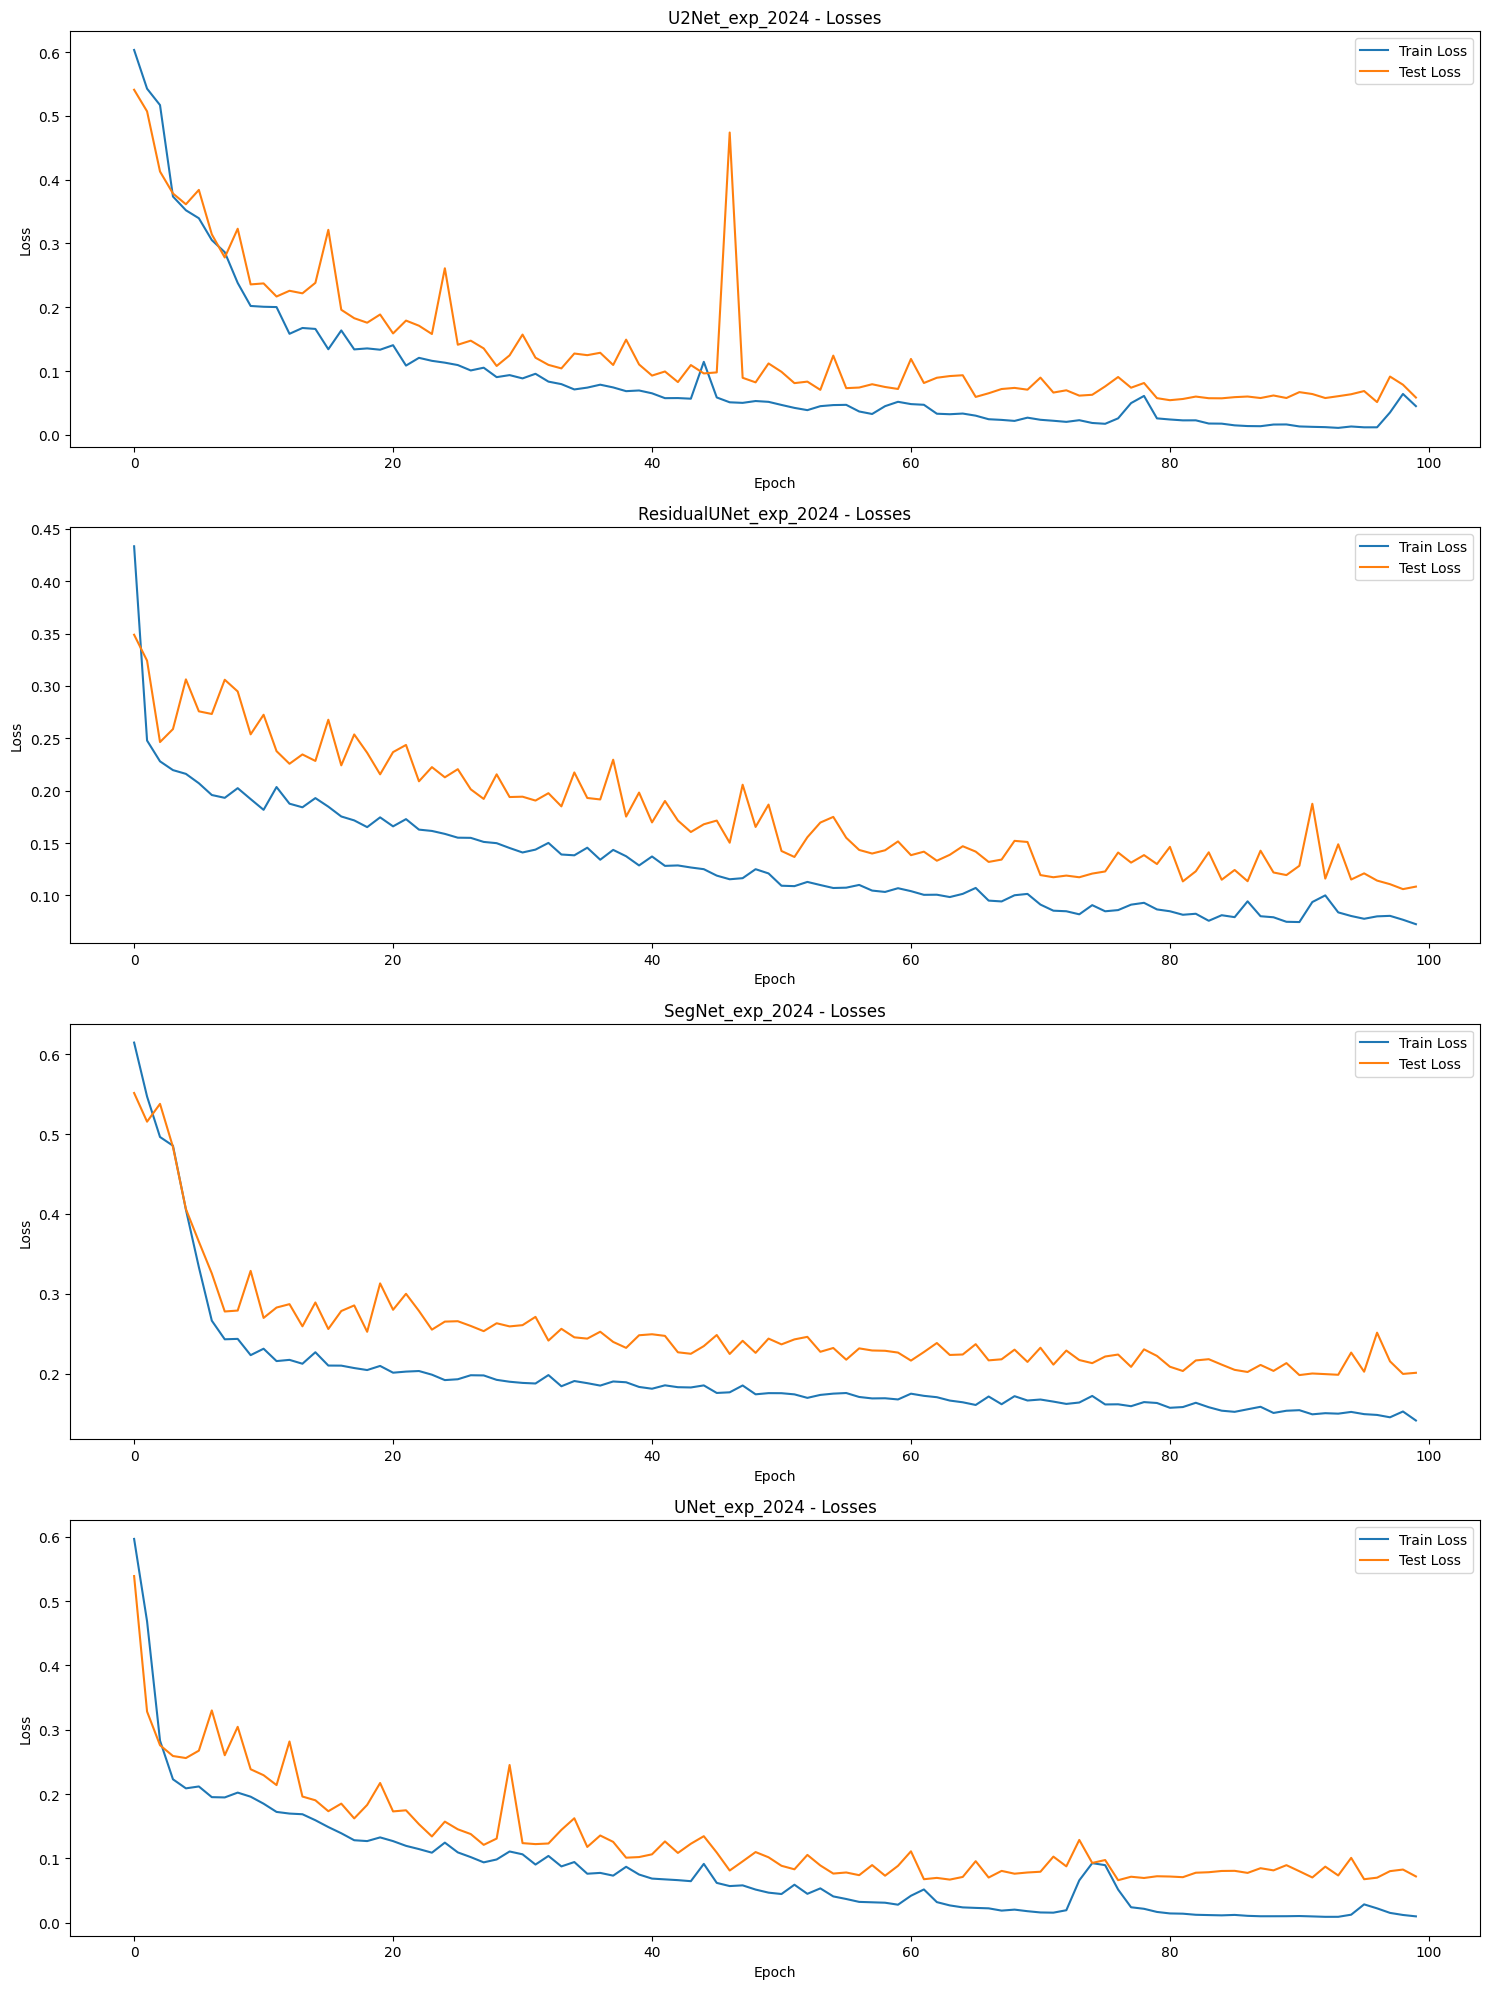

In [ ]:
import json

# Load the data from the JSON file
with open('weights/training_results.json', 'r') as file:
    training_results = json.load(file)

    # Plot training and testing losses for each model on the same plot
    fig, axes = plt.subplots(len(training_results), 1, figsize=(15, 5 * len(training_results)))

    for idx, (model_name, results) in enumerate(training_results.items()):
        train_losses = results['train_losses']
        test_losses = results['test_losses']
        
        # Plot training and testing losses
        axes[idx].plot(train_losses, label='Train Loss')
        axes[idx].plot(test_losses, label='Test Loss')
        axes[idx].set_title(f'{model_name} - Losses')
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel('Loss')
        axes[idx].legend()

    plt.tight_layout()
    plt.show()
